Подключение библиотек и создание SparkSession

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max,lit,floor,regexp_extract
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


pd.set_option('display.max_columns', None)


pd.set_option('display.max_rows', None)


pd.set_option('display.max_colwidth', None)

spark = SparkSession.builder \
    .appName("Spotify EDA") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()


Чтение CSV и первичный просмотр

In [2]:
df = spark.read.option("header", True).csv("data/universal_top_spotify_songs.csv")
pdf_sample = df.limit(5).toPandas()
display(pdf_sample)
df.printSchema()


,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,2RkZ5LkEzeHGRsmDqKwmaJ,Ordinary,Alex Warren,1,1,0,None,2025-06-11,95,False,186964,"You'll Be Alright, Kid (Chapter 1)",2024-09-26,0.368,0.694,2,-6.141,1,0.06,0.704,6.59e-06,0.055,0.391,168.115,3
1,42UBPzRMh5yyz0EDPr6fr1,Manchild,Sabrina Carpenter,2,-1,48,None,2025-06-11,89,True,213645,Manchild,2025-06-05,0.731,0.685,7,-5.087,1,0.0572,0.122,0.0,0.317,0.811,123.01,4
2,0FTmksd2dxiE5e3rWyJXs6,back to friends,sombr,3,0,1,None,2025-06-11,98,False,199032,back to friends,2024-12-27,0.436,0.723,1,-2.291,1,0.0301,9.37e-05,8.82e-05,0.0929,0.235,92.855,4
3,7so0lgd0zP2Sbgs2d7a1SZ,Die With A Smile,"Lady Gaga, Bruno Mars",4,0,-1,None,2025-06-11,91,False,251667,MAYHEM,2025-03-07,0.519,0.601,6,-7.727,0,0.0317,0.289,0.0,0.126,0.498,157.964,3
4,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,Billie Eilish,5,1,0,None,2025-06-11,100,False,210373,HIT ME HARD AND SOFT,2024-05-17,0.747,0.507,2,-10.171,1,0.0358,0.2,0.0608,0.117,0.438,104.978,4


root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: string (nullable = true)
 |-- daily_movement: string (nullable = true)
 |-- weekly_movement: string (nullable = true)
 |-- country: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- is_explicit: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = t

Определение числовых и категориальных колонок

Проверяем, что в числовых колонках числа, если нет — ставим None.
Приводим их к типу float.

In [3]:

numeric_cols = ["daily_rank", "daily_movement", "weekly_movement",
                "popularity", "duration_ms", "danceability", "energy",
                "loudness", "speechiness", "acousticness", "instrumentalness",
                "liveness", "valence", "tempo"]


categorical_cols = ["spotify_id", "name", "artists", "album_name","album_release_date", 
                    "country", "snapshot_date", "is_explicit", 
                    "key", "mode", "time_signature"]


for c in numeric_cols:
    df = df.withColumn(c, when(col(c).rlike("^[+-]?[0-9]*\\.?[0-9]+$"), col(c)).otherwise(None))
    df = df.withColumn(c, col(c).cast("float"))

df.printSchema()



root
 |-- spotify_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- daily_rank: float (nullable = true)
 |-- daily_movement: float (nullable = true)
 |-- weekly_movement: float (nullable = true)
 |-- country: string (nullable = true)
 |-- snapshot_date: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- is_explicit: string (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- time

Проверка пропусков

Считаем количество пропусков (None) в каждой колонке.

Числовые: медиана используется, чтобы не искажать распределение.

Категориальные: пропуски заменяем на "Unknown".

После этого датасет полностью без пустых значений.

In [4]:
misses = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts_pd = misses.toPandas()
missing_counts_pd = missing_counts_pd.T.reset_index()
missing_counts_pd.columns = ["Column", "MissingCount"]
display(missing_counts_pd)

median_dict = {c: df.approxQuantile(c, [0.5], 0.01)[0] for c in numeric_cols}  
df = df.fillna(median_dict)


for c in categorical_cols:
    df = df.fillna({c: "Unknown"})



misses = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_counts_pd = misses.toPandas()
missing_counts_pd = missing_counts_pd.T.reset_index()
missing_counts_pd.columns = ["Column", "MissingCount"]
display(missing_counts_pd)


,Column,MissingCount
0,spotify_id,0
1,name,30
2,artists,29
3,daily_rank,1647
4,daily_movement,1304
5,weekly_movement,1245
6,country,28906
7,snapshot_date,2
8,popularity,403
9,is_explicit,0


,Column,MissingCount
0,spotify_id,0
1,name,0
2,artists,0
3,daily_rank,0
4,daily_movement,0
5,weekly_movement,0
6,country,0
7,snapshot_date,0
8,popularity,0
9,is_explicit,0


Анализ выбросов

Считаем выбросы для каждой числовой колонки по правилу Тьюки (IQR).

Сначала используем 25-й и 75-й квантили для оценки границ выбросов.

Фильтруем выбросы: оставляем только значения внутри [Q1 - 1.5*IQR, Q3 + 1.5*IQR].


In [5]:
conditions = []

for c in numeric_cols:
    Q1, Q3 = df.approxQuantile(c, [0.25, 0.75], 0.0)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    conditions.append((col(c) >= lower) & (col(c) <= upper))


final_condition = conditions[0]
for cond in conditions[1:]:
    final_condition = final_condition & cond


df_clean = df.filter(final_condition)

Статистика числовых признаков

describe() считает min, max, среднее, стандартное отклонение и т.д.

In [6]:
desc_spark = df_clean.select(numeric_cols).describe()

desc_pd = desc_spark.toPandas()

display(desc_pd)



,summary,daily_rank,daily_movement,weekly_movement,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,count,994271,994271,994271,994271,994271,994271,994271,994271,994271,994271,994271,994271,994271,994271
1,mean,24.787538809841582,0.11725374671492983,-0.06315682545302036,78.1578493187471,192047.78593663097,0.6792314277494422,0.6665457047836263,-5.944566510563398,0.07084371457333848,0.26574245062303975,7.305761699756188E-6,0.1471013351158137,0.5648418169266515,120.39512043568266
2,stddev,14.692062679298042,2.2686962188927198,5.4861490722051,13.312775487785288,38166.16553687483,0.13179963790322047,0.14165757420632114,1.9962502871195835,0.04644491061806413,0.23116959360252484,3.606234580823838E-5,0.07616357985238571,0.2197960070404217,26.34946061273948
3,min,1.0,-5.0,-15.0,31.0,84149.0,0.281,0.23,-12.477,0.0219,1.14E-4,0.0,0.0195,0.0334,46.977
4,max,50.0,6.0,17.0,100.0,302500.0,0.98,0.99,-0.161,0.222,0.968,2.59E-4,0.365,0.989,200.002


Визуализация распределения числовых признаков

In [7]:
def spark_histogram(df, column, bins=20):
    
    stats = df.select(
        min(col(column)).alias("min_val"),
        max(col(column)).alias("max_val")
    ).collect()[0]

    min_val = stats["min_val"]
    max_val = stats["max_val"]

    bin_width = (max_val - min_val) / bins

    hist_spark = (
        df
        .withColumn(
            "bin",
            floor((col(column) - min_val) / bin_width)
        )
        .groupBy("bin")
        .agg(count("*").alias("count"))
        .orderBy("bin")
    )


    hist_pd = hist_spark.toPandas()

    hist_pd["bin_center"] = hist_pd["bin"] * bin_width + min_val + bin_width / 2

    plt.figure(figsize=(12,6))
    plt.bar(hist_pd["bin_center"], hist_pd["count"], width=bin_width*0.9)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()


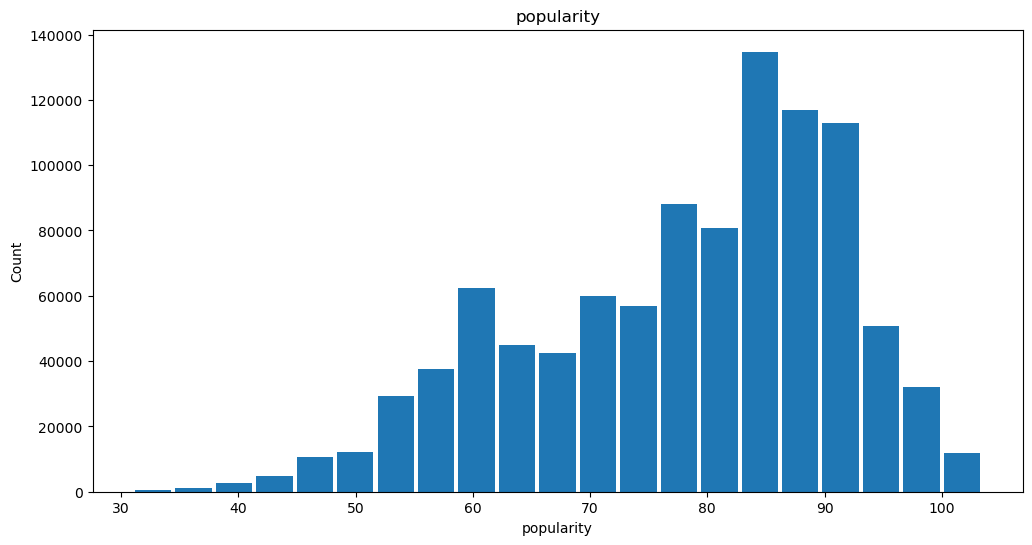

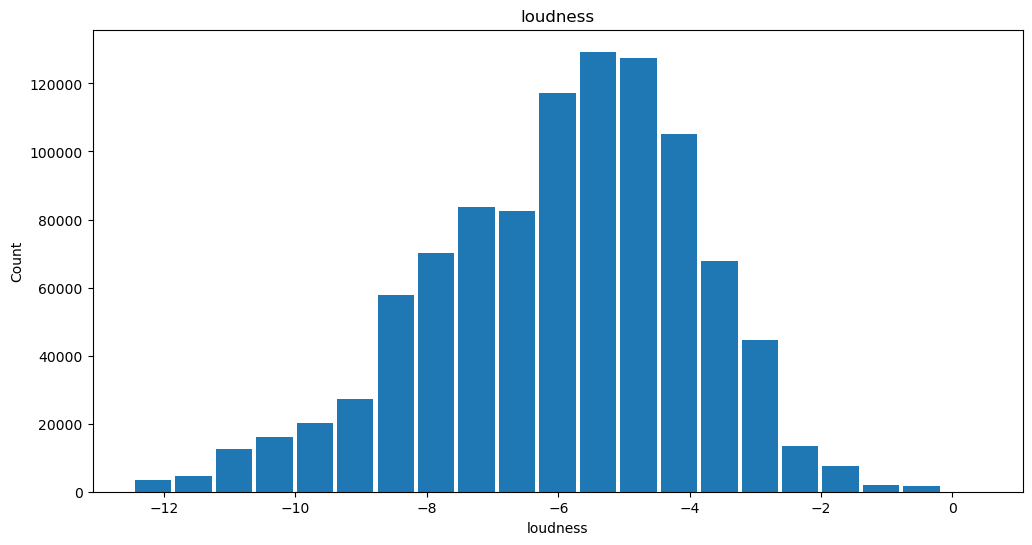

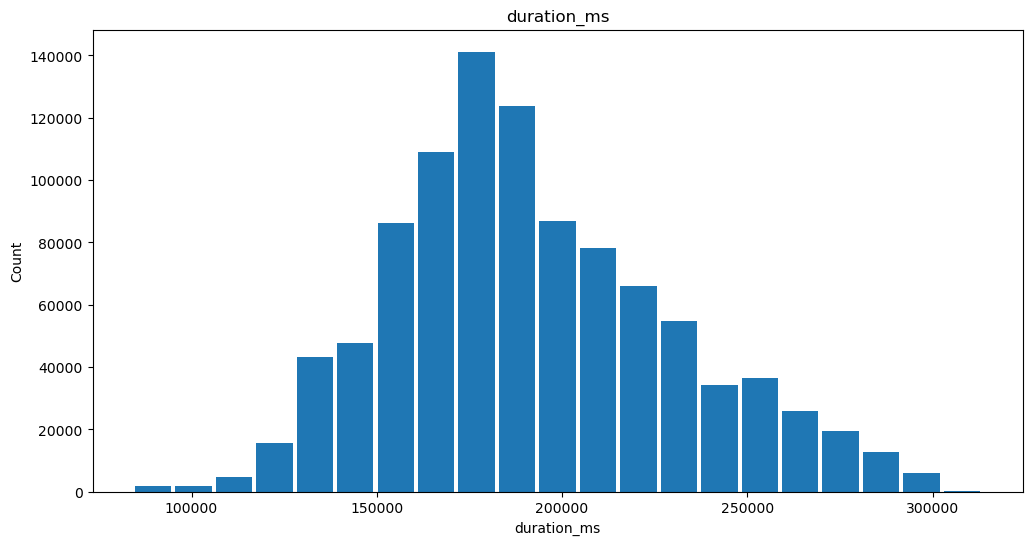

In [8]:
spark_histogram(df_clean, "popularity", bins=20)
spark_histogram(df_clean, "loudness", bins=20)
spark_histogram(df_clean, "duration_ms", bins=20)


Визуализация категориальных признаков

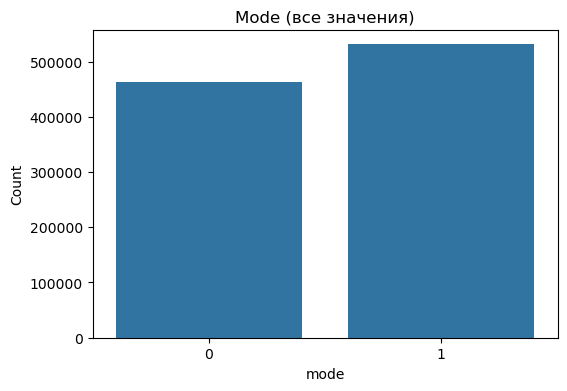

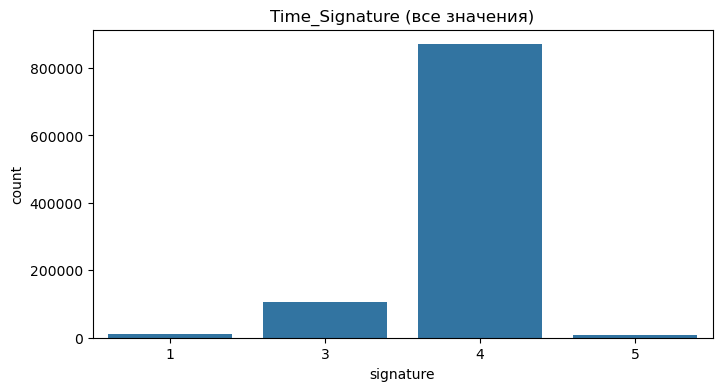

In [9]:

mode_counts = (
    df_clean
    .groupBy("mode")
    .count()
    .orderBy("mode")
)

mode_pd = mode_counts.toPandas()
mode_pd["mode"] = mode_pd["mode"].astype(str)

plt.figure(figsize=(6,4))
sns.barplot(
    x="mode",
    y="count",
    data=mode_pd
)
plt.title("Mode (все значения)")
plt.xlabel("mode")
plt.ylabel("Count")
plt.show()


ts_counts = (
    df_clean
    .groupBy("time_signature")
    .count()
    .orderBy("time_signature")
)

ts_pd = ts_counts.toPandas()
ts_pd["time_signature"] = ts_pd["time_signature"].astype(str)

plt.figure(figsize=(8,4))
sns.barplot(
    x="time_signature",
    y="count",
    data=ts_pd
)
plt.title("Time_Signature (все значения)")
plt.xlabel("signature")
plt.ylabel("count")
plt.show()


Корреляции числовых признаков

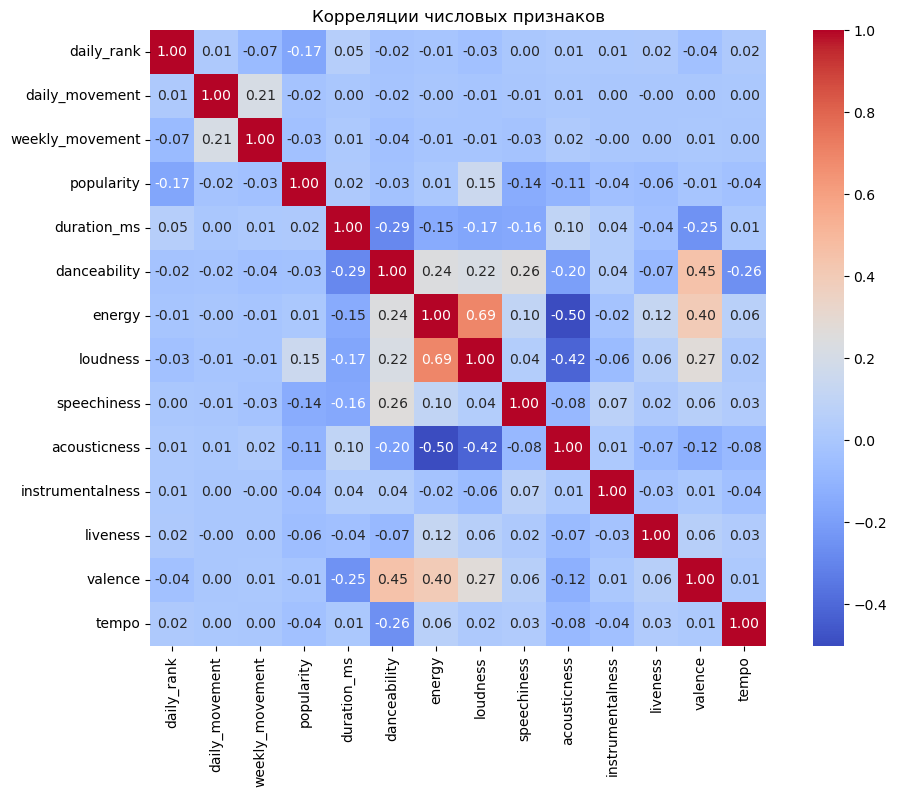

In [10]:
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features"
)

df_vec = assembler.transform(df_clean).select("features")

corr_matrix = Correlation.corr(df_vec, "features", "pearson").head()[0]
corr_pd = pd.DataFrame(
    corr_matrix.toArray(),
    columns=numeric_cols,
    index=numeric_cols
)
plt.figure(figsize=(12,8))
sns.heatmap(
    corr_pd,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Корреляции числовых признаков")
plt.show()
